Rows,Cols: (561, 9)


,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


Pollutants available: ['pm10', 'no2', 'so2', 'co', 'o3']


,count,mean,median,std,min,max
pm10,561.0,420.988414,340.90,271.287026,69.08,1499.27
no2,561.0,75.292496,63.75,42.473791,13.37,263.21
so2,561.0,64.655936,47.21,61.073080,5.25,511.17
co,561.0,3814.942210,2590.18,3227.744681,654.22,16876.22
o3,561.0,30.141943,11.80,39.979405,0.00,164.51


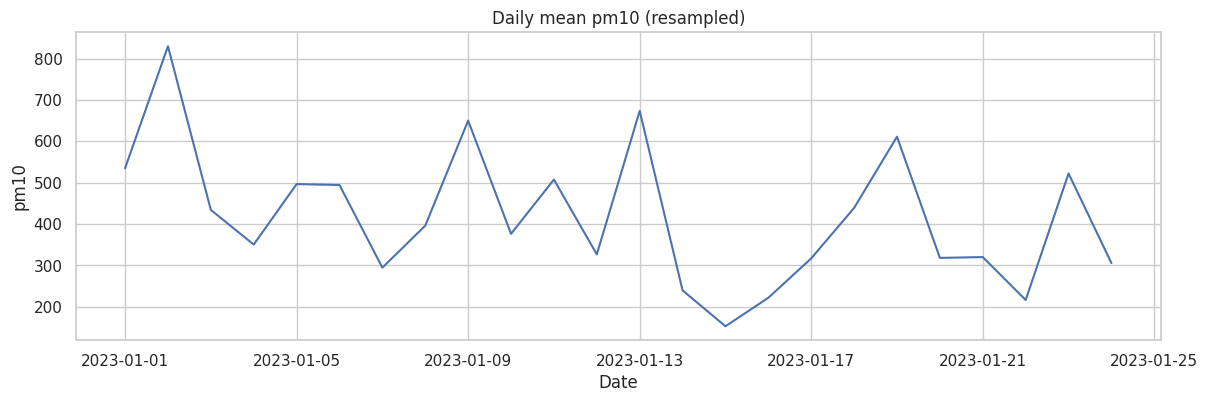

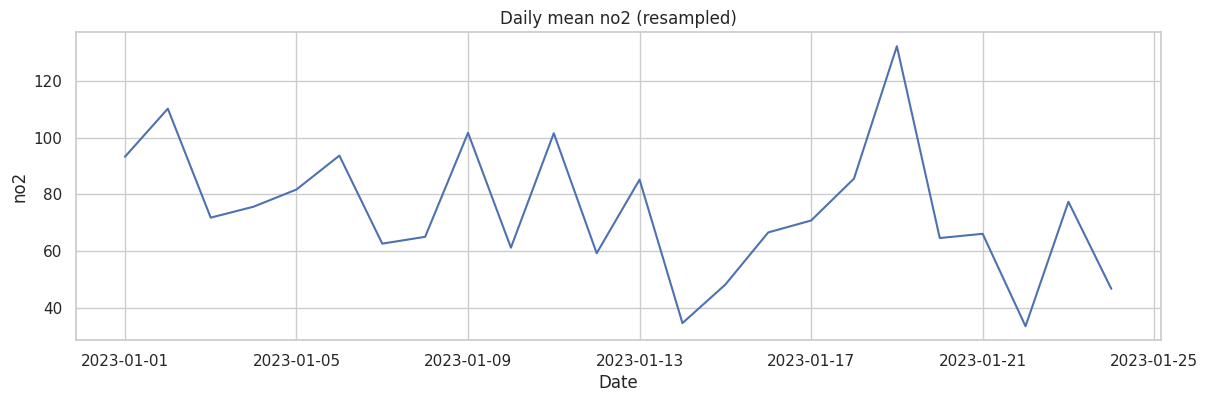

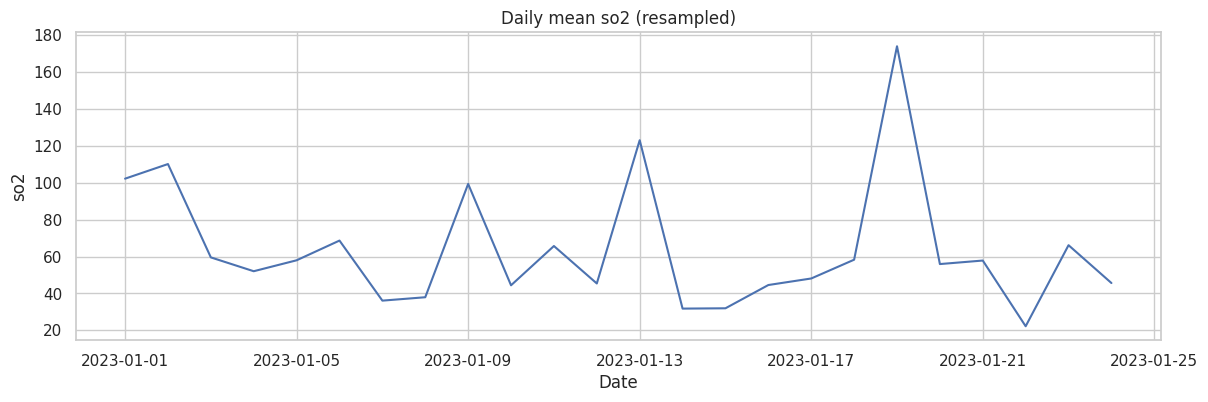

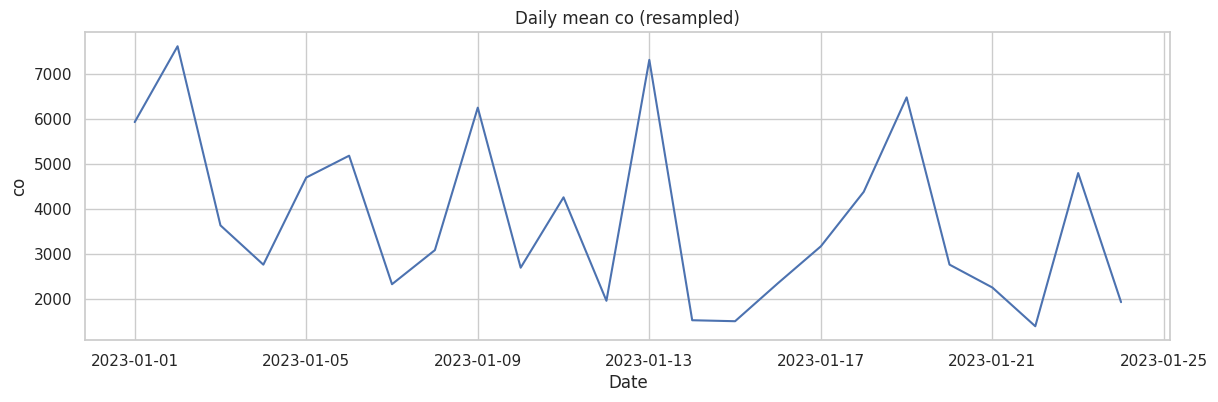

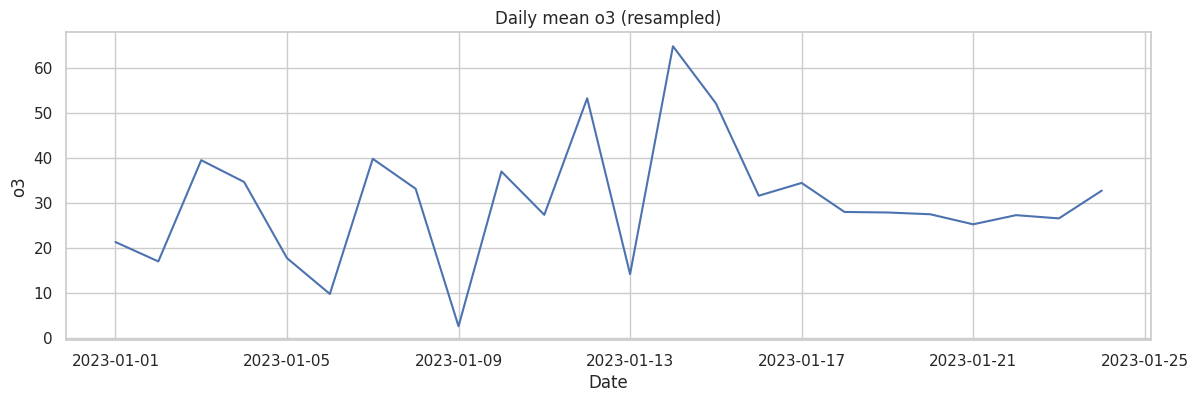

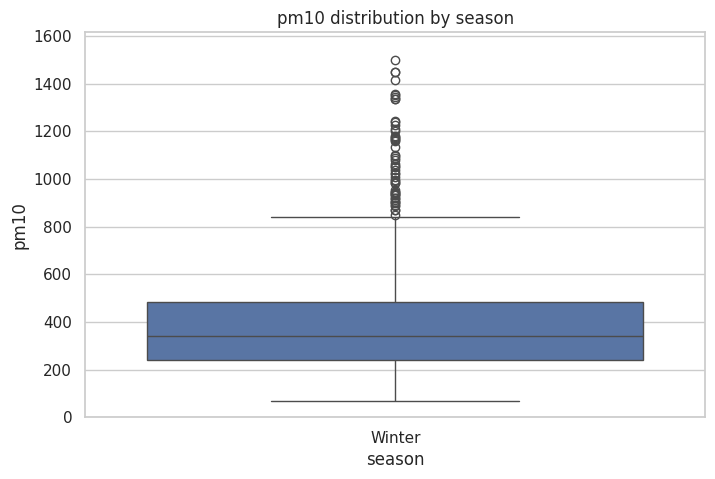

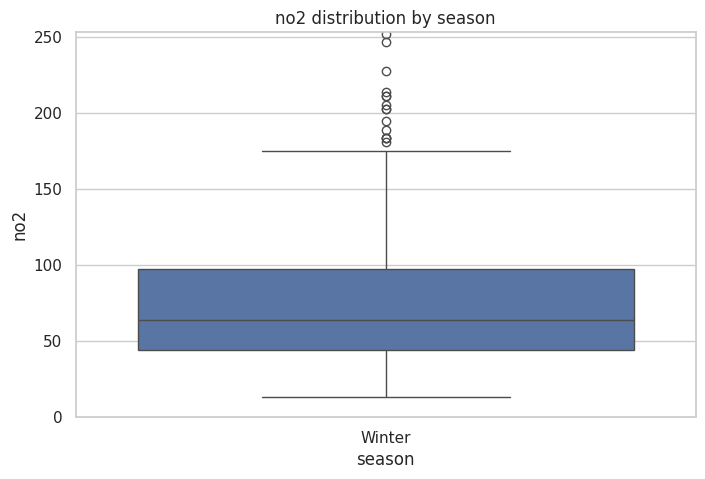

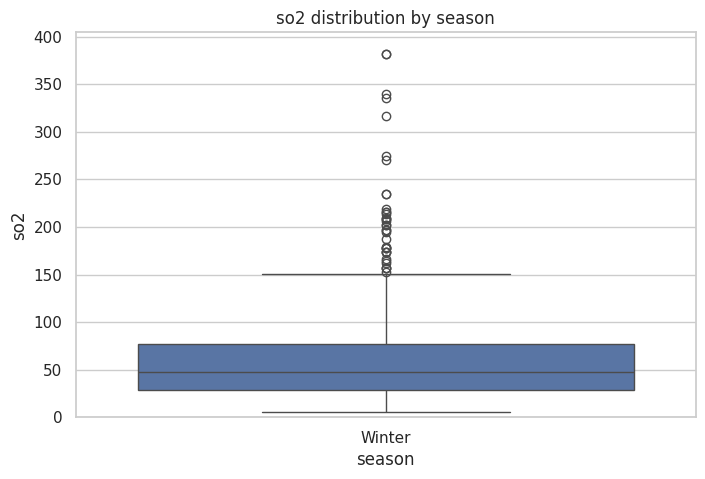

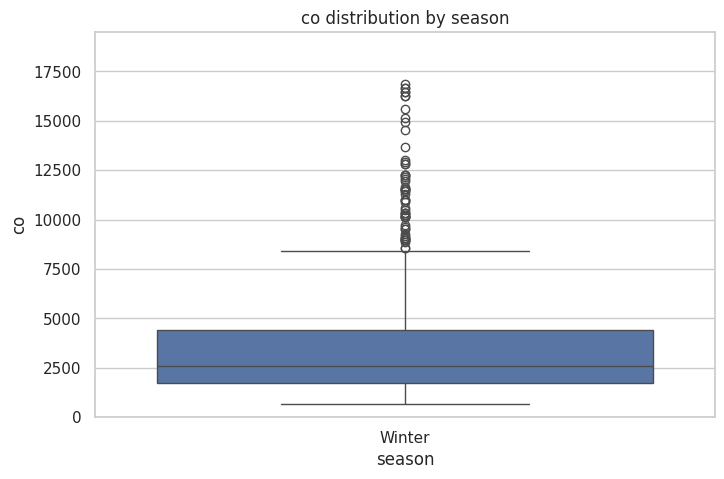

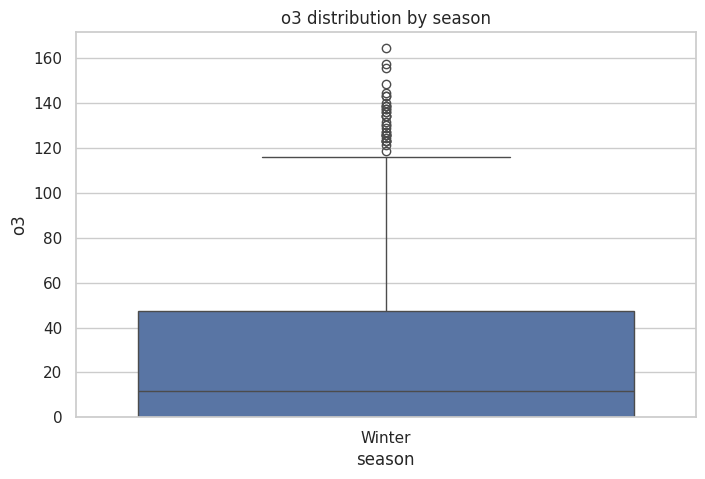

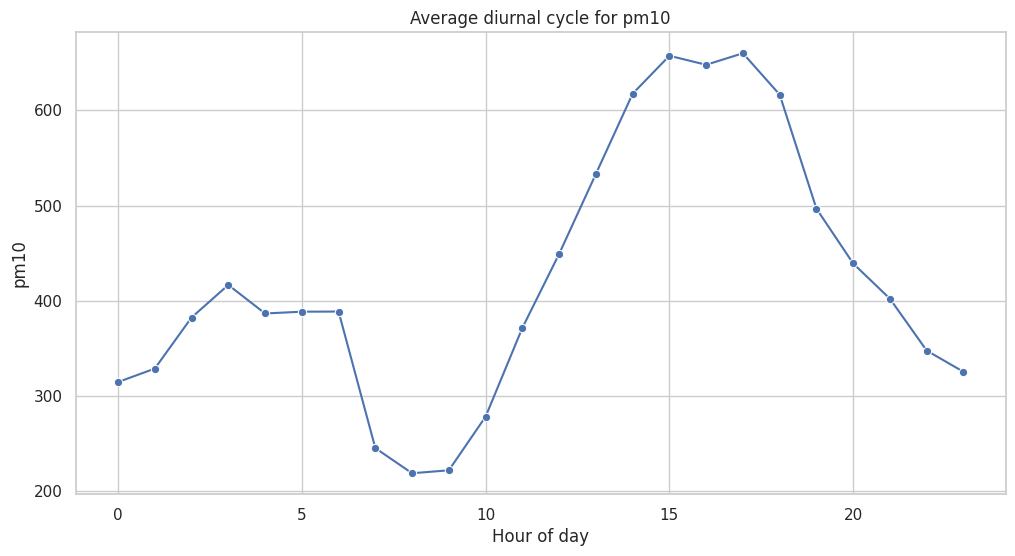

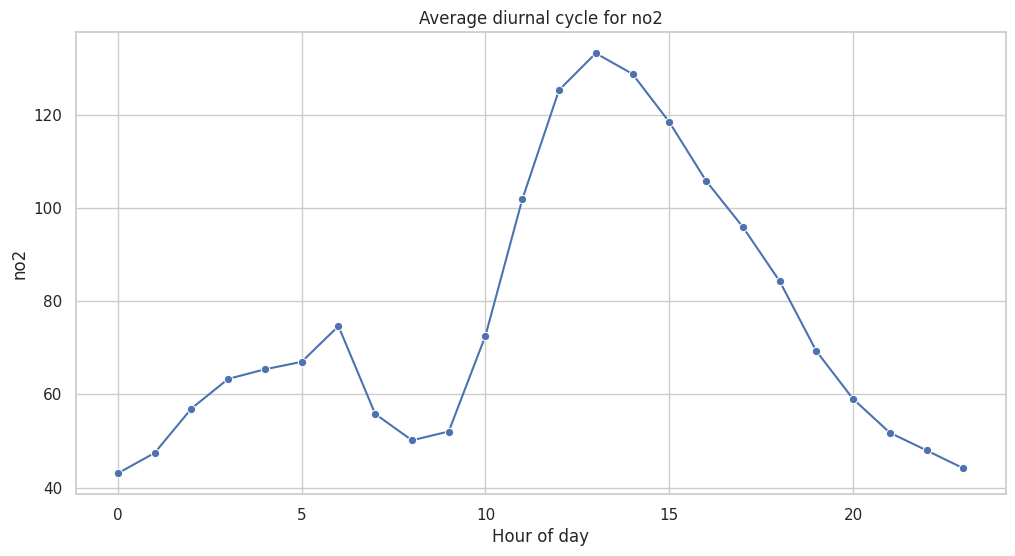

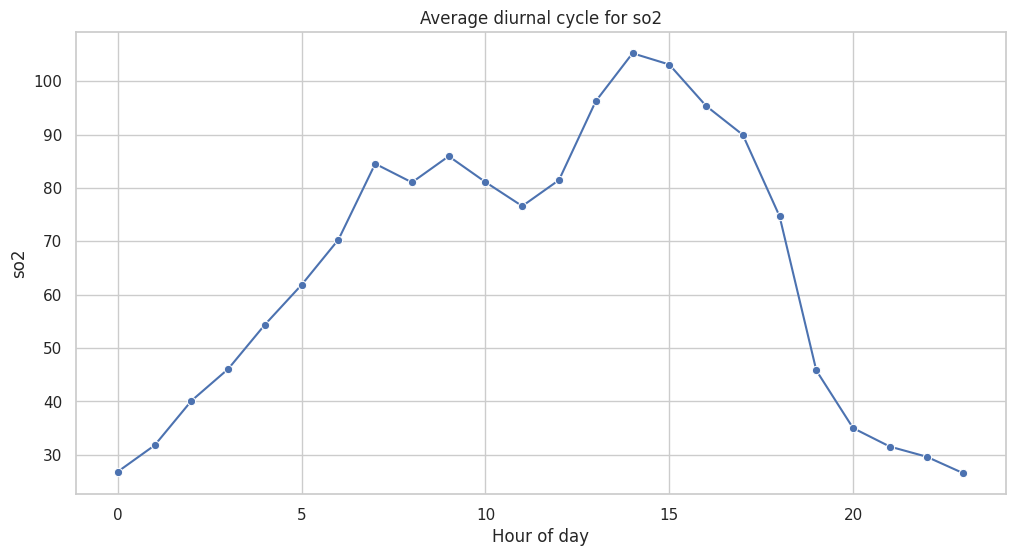

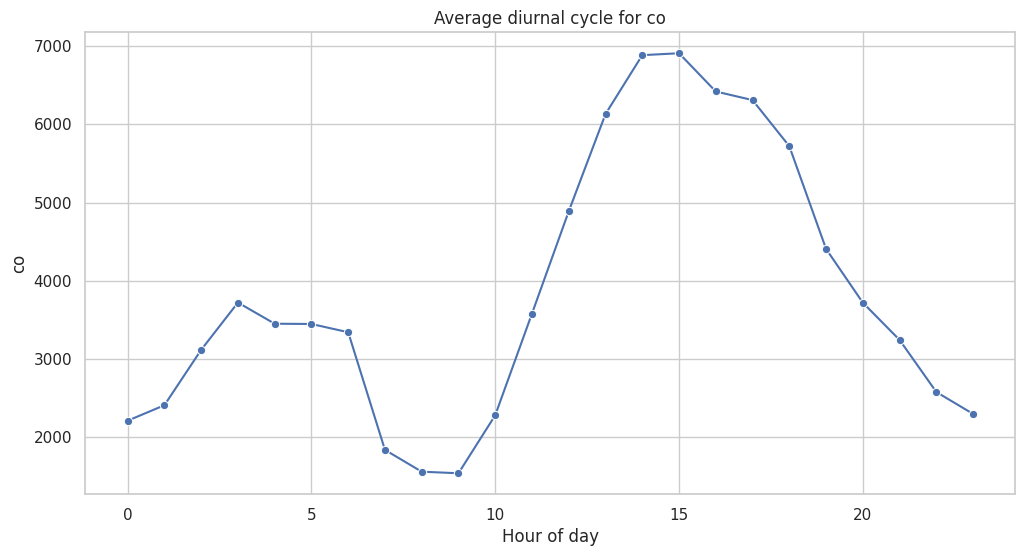

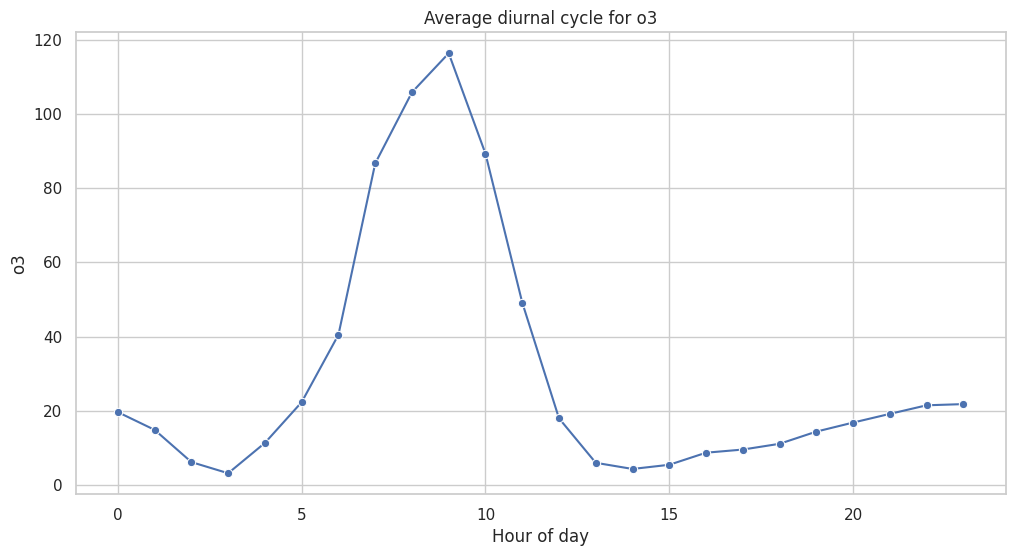

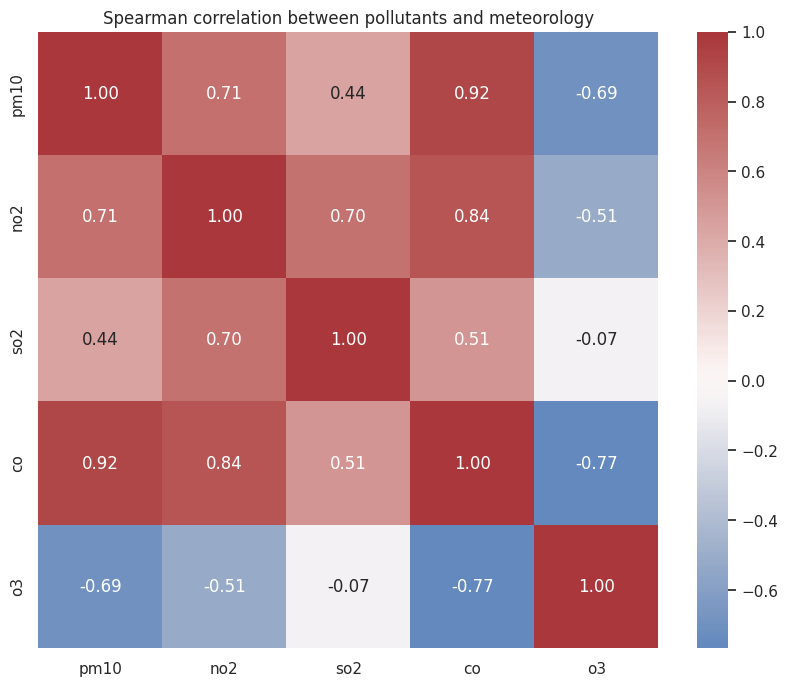

Selected modeling target: pm10

Random Forest predicting pm10 -- MAE: 41.331, RMSE: 58.896

Feature importances:
co       0.954179
no2      0.016461
so2      0.012125
hour     0.010409
o3       0.006827
month    0.000000
dtype: float64
Saved: outputs/rf_feature_importance_pm10.png


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


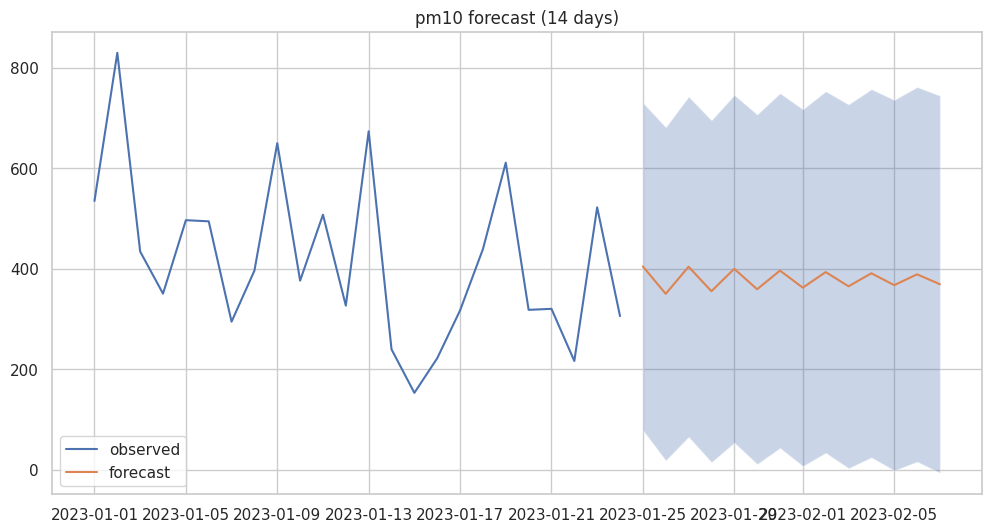

In [6]:
# AQI_Analysis_Delhi.ipynb
# Dependencies:
# pip install pandas numpy matplotlib seaborn statsmodels scikit-learn geopandas folium pymannkendall prophet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pymannkendall as mk  # pip install pymannkendall
# from prophet import Prophet  # optional for time series forecasting
# Optional spatial libs:
# import geopandas as gpd
# import folium

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# -------- USER: point this to your dataset CSV/Excel ----------
DATA_PATH = "delhiaqi (1).csv"
# If you have a folder of CSVs you can adapt: glob them and pd.concat
# -------------------------------------------------------------

# 1. LOAD
if DATA_PATH.endswith(".csv"):
    df = pd.read_csv(DATA_PATH)
elif DATA_PATH.endswith((".xls", ".xlsx")):
    df = pd.read_excel(DATA_PATH)
else:
    raise ValueError("Unsupported file type. Provide CSV or Excel.")

# Quick peek
print("Rows,Cols:", df.shape)
display(df.head())

# 2. CLEAN & PREP
# Standardize column names (lowercase, remove spaces)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Ensure datetime
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    # try common alternatives
    for col in df.columns:
        if 'date' in col or 'time' in col:
            df['timestamp'] = pd.to_datetime(df[col], errors='coerce')
            break
# drop rows without timestamp
df = df.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)

# Fill/note missing pollutant columns
pollutants = [c for c in ['pm2.5','pm10','no2','so2','co','o3','aqi'] if c in df.columns]
print("Pollutants available:", pollutants)

# Example: convert to numeric
for p in pollutants:
    df[p] = pd.to_numeric(df[p], errors='coerce')

# Create datetime features
df['date'] = df['timestamp'].dt.date
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.day_name()

# Imputation strategy: small gaps -> forward fill by station; large gaps leave as NaN
if 'station' in df.columns:
    df = df.sort_values(['station','timestamp'])
    df[pollutants] = df.groupby('station')[pollutants].apply(lambda g: g.ffill().bfill())
else:
    df[pollutants] = df[pollutants].ffill().bfill()

# 3. STATION & OVERALL SUMMARY
def summary_table(df, groupby_col=None):
    cols = pollutants
    if groupby_col:
        s = df.groupby(groupby_col)[cols].agg(['count','mean','median','std','min','max'])
    else:
        s = df[cols].agg(['count','mean','median','std','min','max']).T
    return s

display(summary_table(df))
if 'station' in df.columns:
    display(summary_table(df, 'station'))

# 4. SEASONALIZATION: define seasons for India
def month_to_season(m):
    if m in [12,1,2]: return 'Winter'
    if m in [3,4,5]: return 'Summer'
    if m in [6,7,8,9]: return 'Monsoon'
    if m in [10,11]: return 'PostMonsoon'
df['season'] = df['month'].apply(month_to_season)

# 5. VISUALS: pollutant time series (overall)
for p in pollutants:
    plt.figure(figsize=(14,4))
    df_resampled = df.set_index('timestamp')[p].resample('D').mean()
    plt.plot(df_resampled.index, df_resampled.values)
    plt.title(f'Daily mean {p} (resampled)')
    plt.xlabel('Date'); plt.ylabel(p)
    plt.show()

# 6. BOXPLOTS BY SEASON
for p in pollutants:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='season', y=p, data=df)
    plt.title(f'{p} distribution by season')
    plt.ylim(0, df[p].quantile(0.99)*1.2)  # clip to 99th percentile for clearer plot
    plt.show()

# 7. DIURNAL CYCLE (hourly averages)
for p in pollutants:
    hourly = df.groupby('hour')[p].mean()
    plt.figure()
    sns.lineplot(x=hourly.index, y=hourly.values, marker='o')
    plt.title(f'Average diurnal cycle for {p}')
    plt.xlabel('Hour of day'); plt.ylabel(p)
    plt.show()

# 8. CORRELATIONS
corr_cols = [c for c in pollutants if c in df.columns] + [c for c in ['temperature','humidity','wind_speed'] if c in df.columns]
corr = df[corr_cols].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Spearman correlation between pollutants and meteorology')
plt.show()

# 9. PM2.5/PM10 ratio (source hint)
if 'pm2.5' in df.columns and 'pm10' in df.columns:
    df['pm25_pm10_ratio'] = df['pm2.5'] / (df['pm10'] + 1e-9)
    print("PM2.5/PM10 ratio stats:")
    display(df['pm25_pm10_ratio'].describe())

# 10. TREND TEST (Mann-Kendall) for PM2.5 daily means
if 'pm2.5' in df.columns:
    daily_pm25 = df.set_index('timestamp')['pm2.5'].resample('D').mean().dropna()
    mk_result = mk.original_test(daily_pm25.values)
    print("Mann-Kendall test for PM2.5 daily series:")
    print(mk_result)

# 11. SEASONAL DECOMPOSITION (PM2.5)
if 'pm2.5' in df.columns:
    series = df.set_index('timestamp')['pm2.5'].resample('D').mean().interpolate()
    res = sm.tsa.seasonal_decompose(series, model='additive', period=365//2 if len(series)>365 else 30)
    res.plot()
    plt.show()

# 12. SPATIAL PLOT (if lat/lon exist) - simple scatter map using folium (optional)
if 'latitude' in df.columns and 'longitude' in df.columns and 'station' in df.columns:
    station_avg = df.groupby('station')[['pm2.5','latitude','longitude']].mean().reset_index()
    print("Station-level averages:")
    display(station_avg)
    # Uncomment below if folium is available
    # import folium
    # m = folium.Map(location=[28.61,77.2], zoom_start=10)  # center Delhi approx
    # for _, row in station_avg.iterrows():
    #     folium.CircleMarker(location=[row.latitude, row.longitude],
    #                         radius=7, popup=f"{row.station}: {row['pm2.5']:.1f}",
    #                         fill=True, fill_opacity=0.7).add_to(m)
    # m

# 13. FEATURE IMPORTANCE MODEL: predict PM2.5 using meteorology & co-pollutants
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# choose target: prefer pm2.5 -> aqi -> pm10 -> first pollutant
target = None
for t in ['pm2.5', 'aqi', 'pm10']:
    if t in df.columns:
        target = t
        break
if target is None and pollutants:
    target = pollutants[0]

print("Selected modeling target:", target)

if target:
    # candidate features
    candidate_features = [
        c for c in [
            'pm10', 'no2', 'so2', 'co', 'o3',
            'temperature', 'humidity', 'wind_speed',
            'hour', 'month'
        ]
        if c in df.columns and c != target
    ]

    if candidate_features:
        df_model = df.dropna(subset=[target] + candidate_features)

        if len(df_model) >= 30:
            X = df_model[candidate_features].copy()

            # encode categorical if any (weekday etc.)
            for col in X.select_dtypes(include=['object', 'category']).columns:
                X[col] = pd.Categorical(X[col]).codes

            y = df_model[target]

            # train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            # train RandomForest
            rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            # evaluation
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            print(f"\nRandom Forest predicting {target} -- MAE: {mae:.3f}, RMSE: {rmse:.3f}")

            # feature importances
            importances = pd.Series(rf.feature_importances_, index=candidate_features).sort_values(ascending=False)
            print("\nFeature importances:")
            print(importances)

            # plot feature importances
            fig, ax = plt.subplots(figsize=(7, 4))
            importances.plot.barh(ax=ax)
            ax.invert_yaxis()
            ax.set_title(f"Feature importance for predicting {target}")
            plt.tight_layout()

            # ✅ ensure OUTDIR exists
            OUTDIR = "outputs"
            os.makedirs(OUTDIR, exist_ok=True)

            # save figure
            out = os.path.join(OUTDIR, f"rf_feature_importance_{target.replace('.', '')}.png")
            fig.savefig(out, dpi=150, bbox_inches='tight')
            plt.close(fig)
            print("Saved:", out)

        else:
            print("Not enough rows for modeling. Rows available after dropna:", len(df_model))
    else:
        print("No candidate features found for modeling (need co-pollutants or meteorology).")
else:
    print("No target pollutant found for modeling.")




# 14. EVENT ANALYSIS: compare Oct-Nov (postmonsoon) vs baseline (June-Aug)
if 'month' in df.columns:
    event = df[df['month'].isin([10,11])]
    baseline = df[df['month'].isin([6,7,8])]
    if 'pm2.5' in df.columns:
        from scipy.stats import mannwhitneyu
        stat, pval = mannwhitneyu(event['pm2.5'].dropna(), baseline['pm2.5'].dropna(), alternative='greater')
        print("PM2.5: Oct-Nov vs Jun-Aug Mann-Whitney U test: p =", pval)

# 15. FORECASTING (simple) - aggregate citywide daily mean
# Optional: use Prophet or SARIMA - here's a simple ARIMA example using statsmodels
if target:
    ts = df.set_index('timestamp')[target].resample('D').mean().interpolate()
    # Quick ARIMA (auto_arima would be better but keep simple)
    try:
        # seasonal ARIMA could be applied here
        from statsmodels.tsa.arima.model import ARIMA
        model = ARIMA(ts, order=(2,1,2))
        model_fit = model.fit()
        fc = model_fit.get_forecast(steps=14)
        fc_df = fc.summary_frame()
        plt.figure()
        plt.plot(ts.index[-365:], ts.values[-365:], label='observed')
        plt.plot(fc_df.index, fc_df['mean'], label='forecast')
        plt.fill_between(fc_df.index, fc_df['mean_ci_lower'], fc_df['mean_ci_upper'], alpha=0.3)
        plt.legend()
        plt.title(f'{target} forecast (14 days)')
        plt.show()
    except Exception as e:
        print("ARIMA forecasting failed:", e)

# 16. SAVE SUMMARY REPORTS
# station_avg.to_csv("station_avg_pm25.csv")
# df.to_csv("cleaned_aqi_data.csv", index=False)
